# Random Forest Classifier

In [2]:
from typing import Tuple
import pickle
import numpy as np
import scipy
from scipy.stats import expon
import pandas as pd

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import seaborn as sn

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report

### Load and split the data

In [3]:
# Load the data and split into features and labels
with open('../../data/train.pkl', 'rb') as f:
    data_train = pickle.load(f)
X_data = data_train["images"]
y_data = data_train["labels"]

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, random_state=42)

In [5]:
X_train = X_train.reshape(-1, 32 * 32 * 3)
X_val = X_val.reshape(-1, 32 * 32 * 3)

### Train and evaluate a Random Forest Classifier

We fit the random forest classifier on the training set and evaluate its classification accuracy on the training set and the validation set.

In [6]:
%%time

rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, verbose=1)
rf.fit(X_train, y_train)

y_train_hat = rf.predict(X_train)
print("Train: ", accuracy_score(y_train_hat, y_train))

y_val_hat = rf.predict(X_val)
print("Val:   ", accuracy_score(y_val_hat, y_val))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   27.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.1min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.5s finished


Train:  1.0


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s


Val:    0.46352
CPU times: user 4min 5s, sys: 1.35 s, total: 4min 7s
Wall time: 1min 7s


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.5s finished


To gain more information on the classification errors, we inspect the confusion matrix.

In [7]:
def plot_confusion_matrix(y_true: any, y_pred: any, labels: list):
    """
    Plots confusion matrix for given arrays of predicted and ground-truth labels.

    Args:
        y_true: array of ground-truth labels
        y_pred: array of class predictions
        labels: list of labels
    """
    conf_mat= confusion_matrix(y_true=y_true, y_pred=y_pred, normalize="all")
    plt.figure(figsize=[7.4, 5.8])
    sn.heatmap(conf_mat, annot=True, xticklabels=labels,
               yticklabels=labels, cmap="BuPu")
    plt.title("Confusion Matrix")
    plt.ylabel("true class")
    plt.xlabel("predicted class")
    plt.tight_layout()
    plt.show()  

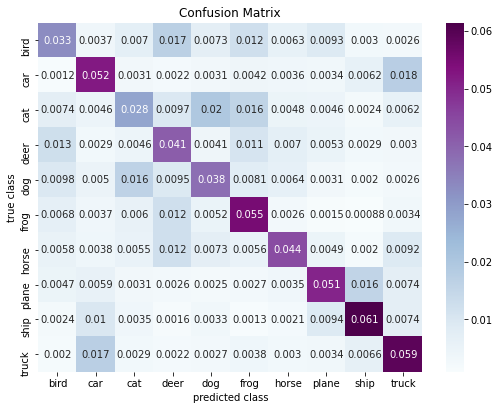

In [8]:
plot_confusion_matrix(y_true=y_val, y_pred=y_val_hat, labels=np.unique(y_data))

Further information on the misclassification can be obtained by looking at different metrices than only accuracy, for example precision and recall. To this end, we plot the sklearn classification report.

In [9]:
def plot_classification_report(classification_report: str, cmap: any):
    """
    Plots classification error based on https://gist.github.com/samuelsmal/815d59a8648d4abfce1f90b2f39089d5

    Args:
        classification_report: report of precision, recall and f1-score as string
        cmap: colour map
    """

    lines = classification_report.split('\n')

    classes = []
    report_matrix = []
    for line in lines[2:12]:
        t = line.split()
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        report_matrix.append(v)

    plt.figure(figsize=[7.4, 5.8])
    sn.heatmap(report_matrix, annot=True, xticklabels=["Precision", "Recall", "F1-score"],
               yticklabels=classes, cmap=cmap)
    plt.title("Classification Report")
    plt.show()

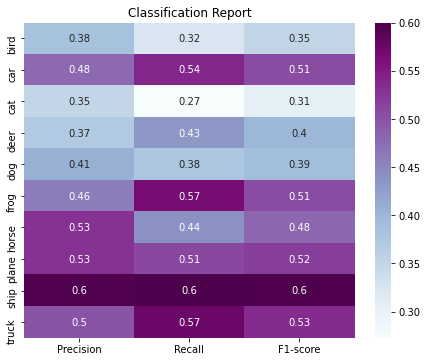

In [10]:
class_report = classification_report(y_true=y_val, y_pred=y_val_hat, target_names=np.unique(y_data), digits=4)
plot_classification_report(classification_report=class_report, cmap="BuPu")

<AxesSubplot:ylabel='count'>

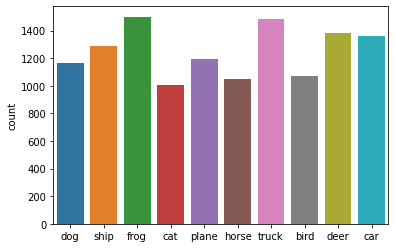

In [11]:
sn.countplot(x=y_val_hat)

<AxesSubplot:ylabel='count'>

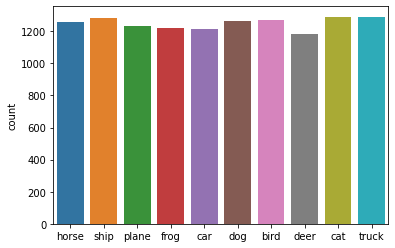

In [12]:
sn.countplot(x=y_val)

### Tune the hyperparameters of the Random Forest model


As a first step of the hyperparameter optimization we conduct a randomized search based on a selection of parameter distributions. The evaluation within the search is based on a 5-fold cross validation.

In [16]:
%%time

param_distributions = {
    "criterion": ["gini", "entropy"],
    "n_estimators": [50, 100, 200], 
    "max_features": ["sqrt", "log2"],
    "ccp_alpha": expon(scale=0.01)}
rf2 = RandomForestClassifier()
clf = RandomizedSearchCV(rf2, param_distributions, n_iter=20, n_jobs=-1, refit=True, cv=5, random_state=42, verbose=1, return_train_score=True)
search = clf.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
CPU times: user 1min 43s, sys: 233 ms, total: 1min 44s
Wall time: 10min 39s


In [17]:
pd.DataFrame.from_dict(search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ccp_alpha,param_criterion,param_max_features,param_n_estimators,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,124.483211,1.493133,0.143757,0.004288,0.00469268,gini,sqrt,50,"{'ccp_alpha': 0.004692680899768591, 'criterion...",0.210133,...,0.214293,0.005567,1,0.218967,0.214900,0.216400,0.213867,0.221667,0.21716,0.002832
1,223.788889,37.375780,0.170165,0.064431,0.0151272,gini,sqrt,100,"{'ccp_alpha': 0.015127241738646855, 'criterion...",0.157467,...,0.159093,0.001269,2,0.160733,0.159833,0.159833,0.162233,0.158867,0.16030,0.001133


We pick the model that achieved the best average score across the search and evaluate it on the validation set. Note that the best model was refitted on the entire training set because we set the parameter refit=True.

In [18]:
rf_best = search.best_estimator_
y_train_hat = rf_best.predict(X_train)
print("Train: ", accuracy_score(y_train_hat, y_train))

y_val_hat = rf_best.predict(X_val)
print("Val:   ", accuracy_score(y_val_hat, y_val))

Train:  0.21122666666666667
Val:    0.20872
